In [ ]:
# pip install seaborn

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
products_concat = pd.read_csv('./dataset/product_concat_v2.csv') 
print(products_concat.shape)
print(products_concat.info())

(751315, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751315 entries, 0 to 751314
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   MEMBER_ID     751315 non-null  object
 1   CATALOG_NM    751315 non-null  object
 2   CATEGORYM_ID  751315 non-null  int64 
 3   KEYWORD       751315 non-null  object
 4   DISPLAY       751315 non-null  int64 
 5   CATALOG_DESC  751315 non-null  object
 6   INPUT_DT      751315 non-null  int64 
 7   UPDATE_DT     751315 non-null  int64 
 8   REMOTEIP      751315 non-null  int64 
 9   SHOW_CHK      751315 non-null  int64 
 10  judge         751315 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 63.1+ MB
None


# 소문자, 불용어, 어근 추출, 단어 토큰 함수

In [2]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# 문장에 포함된 구두점을 삭제하기 위한 맵핑 정보 생성
# ord() : 매개변수로 전달된 문자에 해당하는 유니코드를 반환
# 구두점이 발견되면 : None값으로 대채 -> 즉, 지운다는 뜻

remove_punct_dict = {ord(punct):None for punct in string.punctuation }

lemmar = WordNetLemmatizer()

# 문장 입력받음 -> stopwords를 제거 -> 소문자로 변환 -> 단어로 토큰->어근 변환
def LenNormalize(text):
    tokens = nltk.word_tokenize(text.lower().translate(remove_punct_dict))
    return [lemmar.lemmatize(token) for token in tokens]

### 상품 ['CATALOG_NM'] 영어만 남기기
- 정규 표현식 사용

In [5]:
import re
products_concat['CATALOG_NM'] = products_concat['CATALOG_NM'].apply(lambda x:re.sub('[^a-zA-Z]+',' ',x))

### CountVectorizer()

In [3]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

cnt_vect = CountVectorizer(tokenizer=LenNormalize, stop_words='english', ngram_range = (1,2))
tfidf_vect = TfidfVectorizer(tokenizer=LenNormalize, stop_words='english', ngram_range = (1,2))

catalog_nm_vect = tfidf_vect.fit_transform(products_concat['CATALOG_NM'])
keyword_vect = cnt_vect.fit_transform(products_concat['KEYWORD'])
catalog_desc_vect = tfidf_vect.fit_transform(products_concat['CATALOG_DESC'])

### CountVectorizer() 형태

In [5]:
print('CATALOG_NM: ', catalog_nm_vect.shape)
print('KEYWORD: ', keyword_vect.shape)
print('CATALOG_DESC: ', catalog_desc_vect.shape)

CATALOG_NM:  (751315, 1356157)
KEYWORD:  (751315, 1309447)
CATALOG_DESC:  (751315, 13887408)


## 실루엣 계수 분석 (안됨)

In [88]:
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

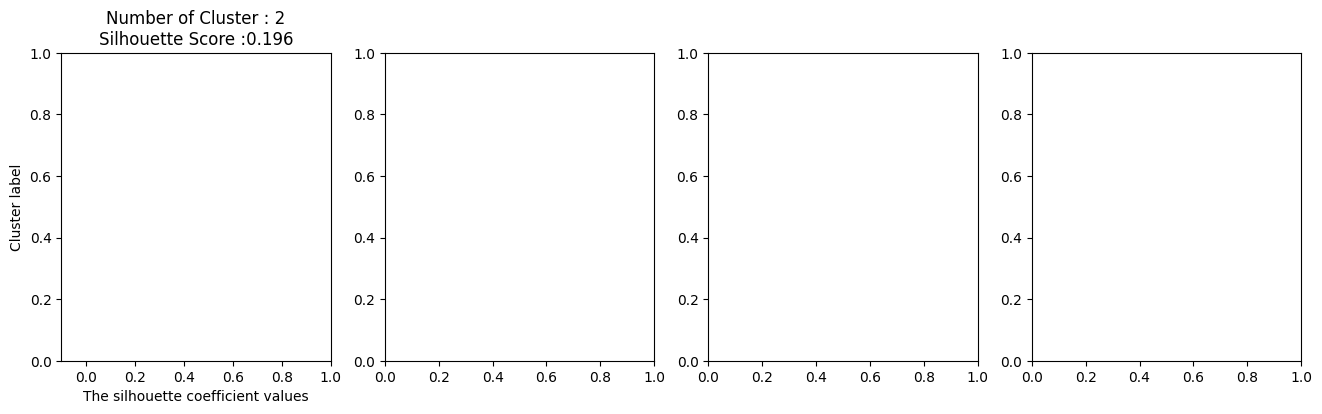

In [89]:
from sklearn.datasets import make_blobs  # 클러스터링을 위한 샘플데이터 제공해주는 데이터
import numpy as np


visualize_silhouette([2,3,4,5], x_under)

In [ ]:
visualize_silhouette([2,3,4,5], catalog_nm_vect) # 클러스터 수 변화

## 언더 샘플링 시도
- 상품간의 격차가 커 군집이 되지 않는다고 예상
- 언더 샘플링 이후 다시 데이터 프레임 넣는 방법 아는 사람..? 

In [ ]:
# pip install imblearn

In [4]:
from imblearn.under_sampling import TomekLinks
from collections import Counter


tometlink = TomekLinks(sampling_strategy = 'not majority')
x = catalog_nm_vect
y = products_concat['judge']
x_under,y_under = tometlink.fit_resample(x,y)
print(Counter(y_under))

In [ ]:
x = pd.DataFrame(data=[x_under,y_under])

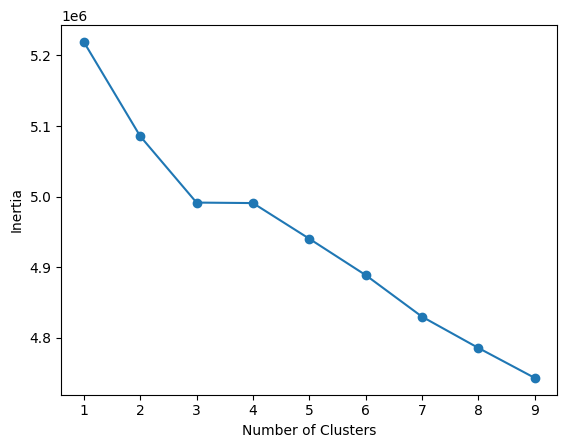

In [81]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_range = range(1,10)

inertia_arr = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state= 10)
    kmeans.fit(x_under) # 학습
    inertia_arr.append(kmeans.inertia_)

# Elbow function 그리기
plt.plot(k_range, inertia_arr, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

## v2) (언더샘플링 후) 최적의 k = 3

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

km_cluster = KMeans(n_clusters=3, max_iter= 20000, random_state= 0)
km_cluster.fit(np.array(x_under))
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

products_concat['cluster_label'] = cluster_label

In [ ]:
feature_names = cnt_vect.get_feature_names_out()
print(feature_names.shape)
print(feature_names)

## v1) (언더샘플링 없이)군집화 전 최적의 k 찾기
- 중국어 포함
- catalog_nm_vect, catalog_desc_vect

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
import matplotlib.pyplot as plt

# 희소 행렬을 수평으로 합치기
combined_vect = hstack([catalog_desc_vect, catalog_nm_vect])

normalized_vect = normalize(combined_vect)

k_range = range(1,10)

inertia_arr = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state= 10)
    kmeans.fit(normalized_vect) # 학습
    inertia_arr.append(kmeans.inertia_)

# Elbow function 그리기
plt.plot(k_range, inertia_arr, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
    
KeyboardInterrupt: 


### 최적의 k= 3 의 경우

In [13]:
from sklearn.cluster import KMeans

km_cluster = KMeans(n_clusters=5, max_iter= 20000, random_state= 0)
km_cluster.fit(catalog_nm_vect,catalog_desc_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

products_concat['cluster_label'] = cluster_label

In [14]:
products_concat['cluster_label'].value_counts()

cluster_label
3    690625
1     23939
0     21640
4     10421
2      4690
Name: count, dtype: int64

In [15]:
cluster_centers = km_cluster.cluster_centers_
print('클러스터 형태: ', cluster_centers.shape)
print(cluster_centers)

클러스터 형태:  (5, 1356157)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.86410694e-07 2.86410694e-07 8.07311571e-07 ... 6.20455335e-07
  8.49934008e-07 8.49934008e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [17]:
products_concat[products_concat['cluster_label']==2][['CATALOG_NM','CATALOG_DESC','judge','cluster_label']].sort_values(by = 'CATALOG_NM')

,CATALOG_NM,CATALOG_DESC,judge,cluster_label
195935,Chemical,"we sale research chemical, ssd chemical soluti...",0,2
186991,Chemical,"Do you have black currency in form of Dollars,...",0,2
108912,Chemical,WE HAVE THE ORIGINAL LATEST 2021 SUPER AUTOMAT...,0,2
205451,Chemical,Product name Testosterone Enanthate \r\n...,0,2
205449,Chemical,Testosterone Acetate (Steroids) \r\nOther name...,0,2
...,...,...,...,...
728045,Chemicals,Betamethasone 21-acetate \n\r\nEnglish Synonym...,1,2
728032,Chemicals,"\r\nEcdysone\n\r\nEnglish Synonyms: 2,3,14,22,...",1,2
208773,Chemicals,Prednisolone\r\nSynonyms: DEHYDROHYDROCORTI...,0,2
208855,Chemicals,\r\nProduct name Testosterone Sustanon (Ste...,0,2


In [18]:
def get_cluster_details(model, cluster_data, feature_names, cluster_num, top_n =10):
    ordered_idx = model.cluster_centers_.argsort()[:,::-1]   # 군집별 중심으로 부터 상대적 군집 거리를 가져옴
    
    # 결과 포맷
    # {0: {'cluster':0, 'top_features':[...]}, {1: ... },} 키: 군집 번호
    cluster_details = {}
    for cluster_num in range(cluster_num):
        cluster_details[cluster_num] = {}  # 키
        
        cluster_details[cluster_num]['cluster']  = cluster_num # 0번째 키
        top_feature_index = ordered_idx[cluster_num, : top_n]  # 내림차순 정렬된 
        
        top_features = [ feature_names[idx] for idx in top_feature_index]  # 핵심단어 n개
        cluster_details[cluster_num]['top_features'] = top_features

    return cluster_details

In [19]:
feature_names = cnt_vect.get_feature_names_out()
print(feature_names.shape)
print(feature_names)

(1309447,)
['0' '0 1' '0 3' ... '，pet' '，pet supply' '：72496414']


In [21]:
cluster_details = get_cluster_details(km_cluster, catalog_nm_vect, feature_names, cluster_num= 6, top_n= 10)

for cluster_num , cluster_detail in cluster_details.items():
    print(f'cluster num: {cluster_num}')
    print(f'top features: {cluster_detail["top_features"]}')
    print('-'*40)

IndexError: index 1328364 is out of bounds for axis 0 with size 1309447

### 최적의 k= 4 의 경우

In [2]:
from sklearn.cluster import KMeans
km_cluster = KMeans(n_clusters=4, max_iter= 20000, random_state= 0)
km_cluster.fit(catalog_nm_vect,catalog_desc_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

products_concat['cluster_label'] = cluster_label

products_concat['cluster_label'].value_counts()

NameError: name 'catalog_nm_vect' is not defined

## v1) (언더샘플링 없이)군집화 전 최적의 k 찾기
- keyword_vect, catalog_desc_vect

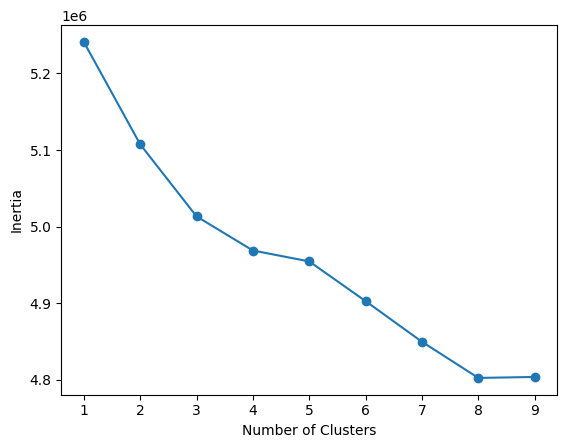

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_range = range(1,10)

inertia_arr = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state= 10)
    kmeans.fit(keyword_vect,catalog_desc_vect) # 학습
    inertia_arr.append(kmeans.inertia_)

# Elbow function 그리기
plt.plot(k_range, inertia_arr, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [22]:
from sklearn.cluster import KMeans

km_cluster = KMeans(n_clusters=4, max_iter= 20000, random_state= 0)
km_cluster.fit(catalog_nm_vect,catalog_desc_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

products_concat['cluster_label'] = cluster_label

In [28]:
products_concat['cluster_label'].value_counts()

In [29]:
cluster_centers = km_cluster.cluster_centers_
print('클러스터 형태: ', cluster_centers.shape)
print(cluster_centers)

cluster_label
1    295819
2     11459
0     10297
4     10043
3      9726
Name: count, dtype: int64

In [31]:
products_concat[products_concat['cluster_label']==0].sort_values(by = 'KEYWORD').head()

,MEMBER_ID,CATALOG_NM,CATEGORYM_ID,KEYWORD,DISPLAY,CATALOG_DESC,INPUT_DT,UPDATE_DT,REMOTEIP,SHOW_CHK,judge,cluster_label
87461,appleshopworld29,Brand NEW Appls Iphons Pro GB Galaxy S Play S...,3809,"100% Brand NEW Appls Iphons 12,13 Pro 512GB G...",1,!! Please stay safe and stay indoors !!....Fee...,20211016,20211016,1972107976,0,0,0
115521,jinive2531,Brand New Appls Iphons X Pro Max gb Guaranteed,3809,"100% Brand New Appls Iphons X,11,12 Pro Max 5...",1,Description\r\nWhatsapp : +1 (862) 2082772\r\...,20210126,20210126,20618919539,1,0,0
88065,appleshopworld23,Free Shipping Appls Iphons Pro GB Galaxy S Pl...,3809,"100% Free Shipping Appls Iphons 12,13 Pro 512...",1,!! Please stay safe and stay indoors !!....Fee...,20211010,20211012,1972105583,0,0,0
145045,rgfbr474,AVAILABLE STOCK for Appls Iphons PRO MAX X XS...,3809,"AVAILABLE STOCK for Appls Iphons 11 PRO MAX,8...",1,BRAND NEW ORIGINAL SEALED IN BOX WITH COMPLETE...,20200620,20200622,123103125235,0,0,0
145039,dgddn3388,AVAILABLE STOCK for Appls Iphons PRO MAX X XS...,3809,"AVAILABLE STOCK for Appls Iphons 11 PRO MAX,8...",1,BRAND NEW ORIGINAL SEALED IN BOX WITH COMPLETE...,20200620,20200622,15718514490,0,0,0


In [33]:
feature_names = cnt_vect.get_feature_names_out()
print(feature_names.shape)
print(feature_names)

(4932513,)
['\x08kaew' '\x08kaew mango' '\x10' ... '\U00100020ux voltage'
 '\U00100025ux' '\U00100025ux 100w']


In [35]:
cluster_details = get_cluster_details(km_cluster, catalog_nm_vect, feature_names, cluster_num= 5, top_n= 10)

for cluster_num , cluster_detail in cluster_details.items():
    print(f'cluster num: {cluster_num}')
    print(f'top features: {cluster_detail["top_features"]}')
    print('-'*40)

cluster num: 0
top features: ['0211a060ff000000024dc08 079158j', '2paraffin industry3deep', '1in 5', '2065℃ internal', '1inch 20mp', '32 layer', '15tfm', '15tons20 ‘', '0215 secondswide', '2560memory']
----------------------------------------
cluster num: 1
top features: ['23831360', '2160connectivity', '2553ply nonwovenspanstrong', '16 ～', '50 clear', '2500（a7） 2000（a9）', '144 resistance', '20320596 名称：', '0455mminbevel angle', '36vmax power150']
----------------------------------------
cluster num: 2
top features: ['175000', '220voutput', '4 tener', '220v±10power', '304 consists', '4all product', '20kg master', '1year warrantycanon', '1753\u202c', '1756l62 allen']
----------------------------------------
cluster num: 3
top features: ['2553ply nonwovenspanstrong', '370w6power supply380v3ph1050hz7max', '100×100 150×150', '220240mm product', '12pl', '12schargerbr', '2430x1000x1780mm', '144489cas', '107x106x102cm computer', '1445085777 molecular']
----------------------------------------

## pairplot 확인

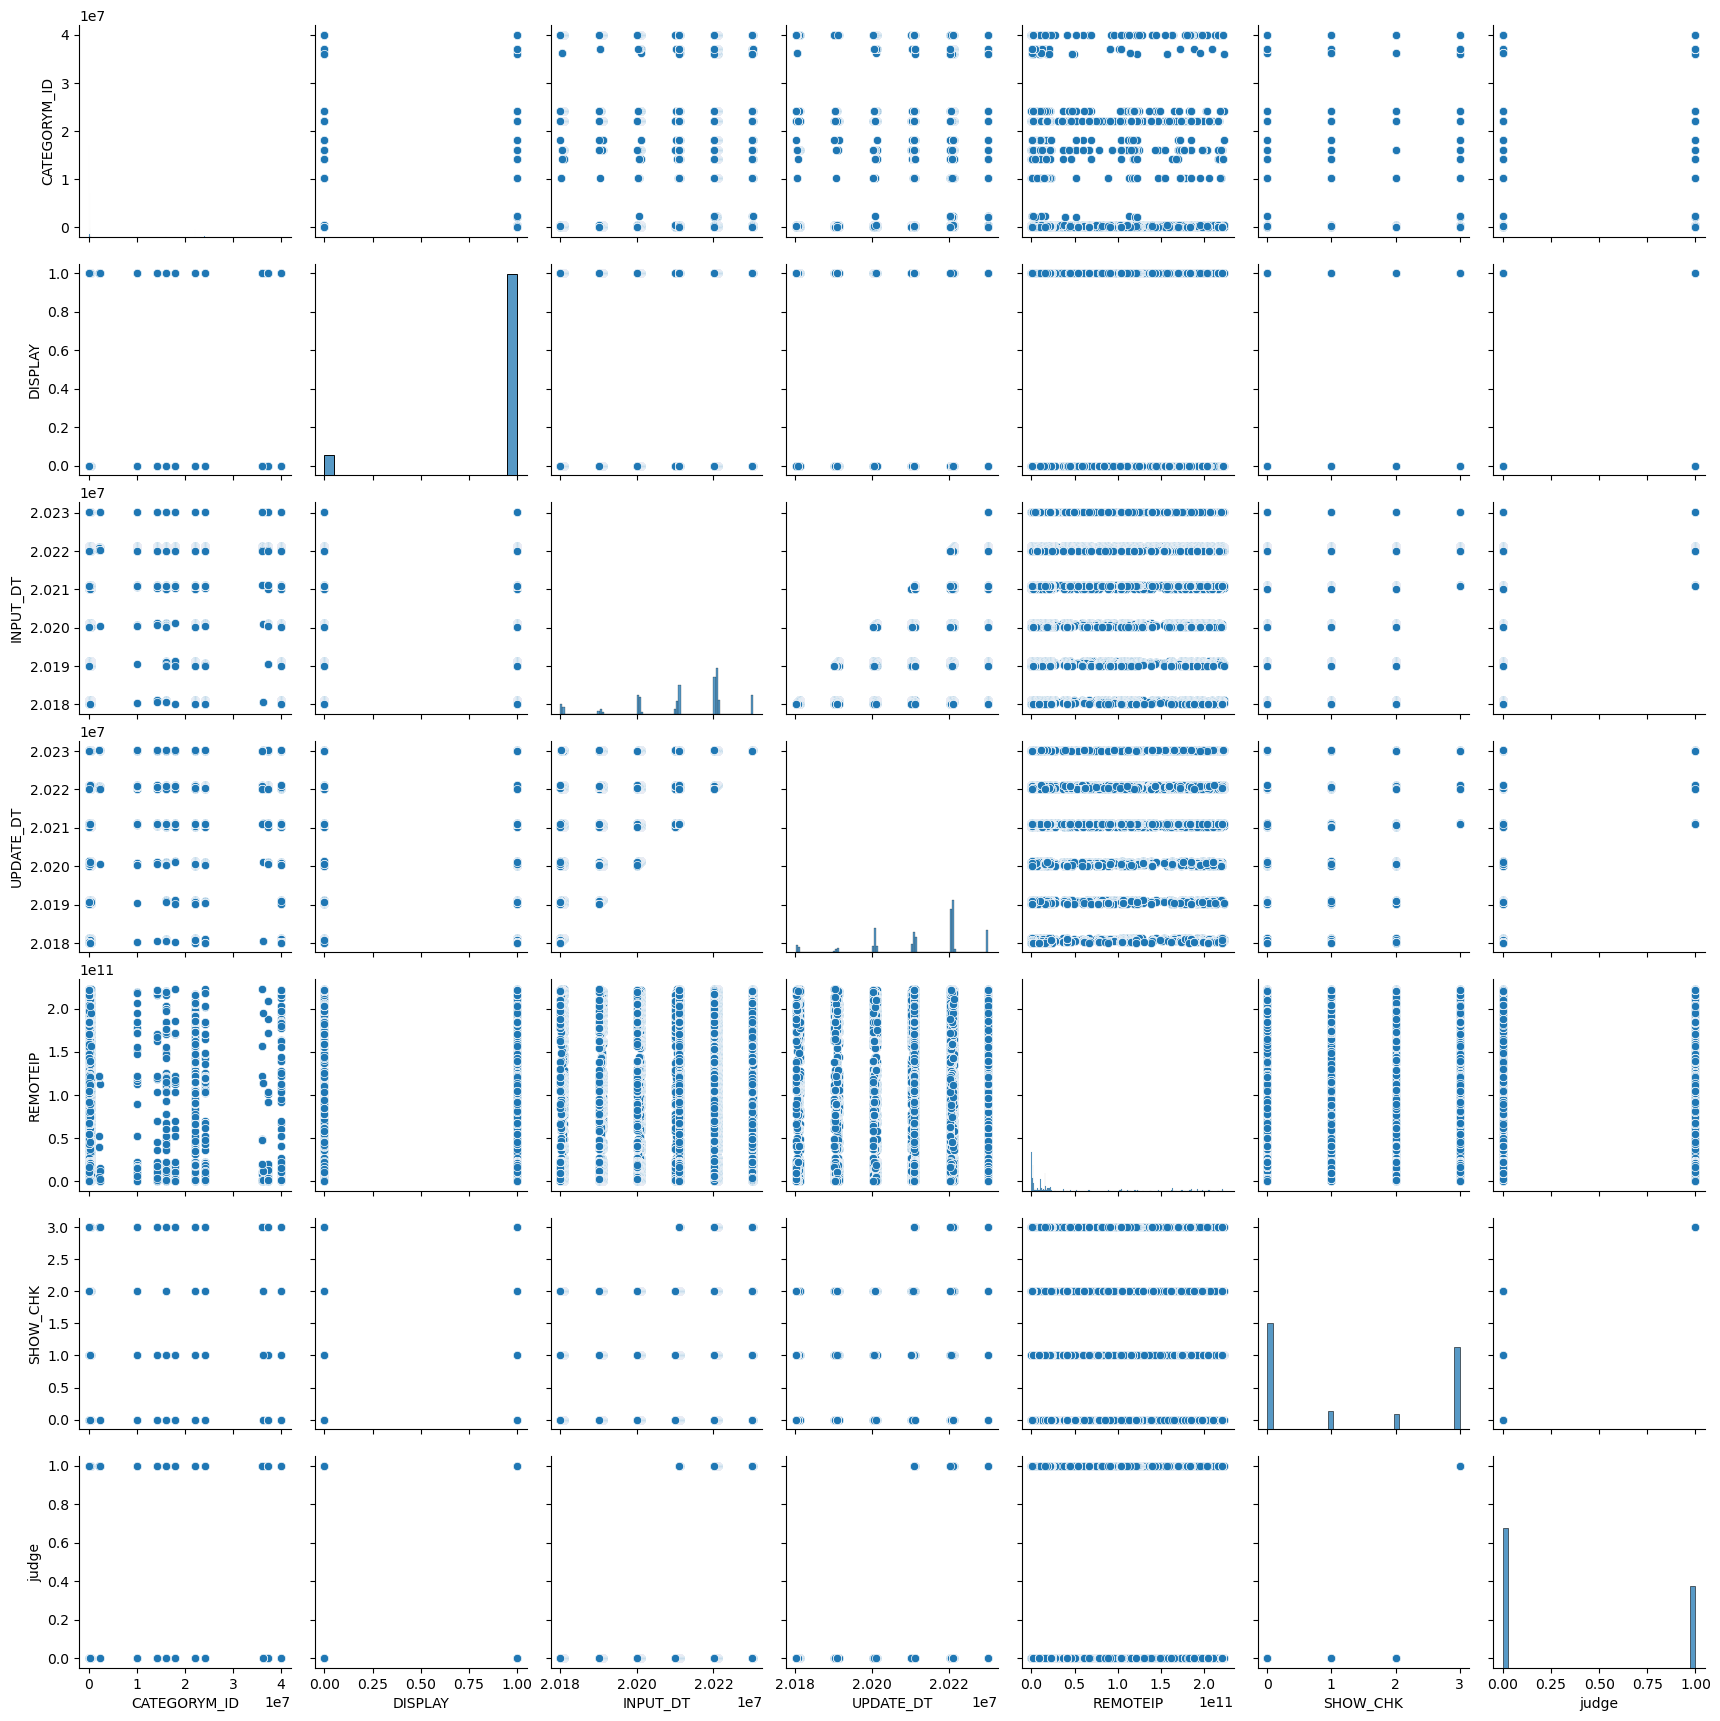

In [10]:
sns.pairplot(products_concat)
plt.show()